In [12]:
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [13]:
ratings_data = pd.read_csv('ml-1m/ratings.dat',sep='::',names=['userId','movieId','rating','timestamp'],dtype=np.float32)

In [14]:
movie_data = pd.read_csv('ml-1m/movies.dat',sep='::',names=['movieId','title','genres'])
movies_n = movie_data['movieId'].max()

In [15]:
users_data = pd.read_csv('ml-1m/users.dat',sep='::',names=['userId','gender','age','occupation','zip-code'])
users_n = users_data['userId'].max()

In [16]:
users_data.head()

,userId,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [11]:
ratings_data.head()

,userId,movieId,rating,timestamp
0,1.0,1193.0,5.0,978300736.0
1,1.0,661.0,3.0,978302080.0
2,1.0,914.0,3.0,978301952.0
3,1.0,3408.0,4.0,978300288.0
4,1.0,2355.0,5.0,978824320.0


In [78]:
demo = ratings_data[['userId','movieId']]

In [79]:
demo = demo.reindex(demo['userId'])
demo.head()

,userId,movieId
userId,,
1.0,1.0,661.0
1.0,1.0,661.0
1.0,1.0,661.0
1.0,1.0,661.0
1.0,1.0,661.0


In [80]:
demo = demo.drop('userId',axis=1)
demo.head()

,movieId
userId,
1.0,661.0
1.0,661.0
1.0,661.0
1.0,661.0
1.0,661.0


In [81]:
demo.T

userId,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,6040.0,6040.0,6040.0,6040.0,6040.0,6040.0,6040.0,6040.0,6040.0,6040.0
movieId,661.0,661.0,661.0,661.0,661.0,661.0,661.0,661.0,661.0,661.0,...,1952.0,1952.0,1952.0,1952.0,1952.0,1952.0,1952.0,1952.0,1952.0,1952.0


In [82]:
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [83]:
print(users_data.shape,movie_data.shape,ratings_data.shape)

(6040, 5) (3883, 3) (1000209, 4)


In [84]:
movie_data['movieId'].nunique()

3883

In [85]:
users_data['gender'] = users_data['gender'].apply(lambda x: 1 if x=='M' else 0)

In [86]:
movie_data['year'] = movie_data['title'].apply(lambda x:x.split(' ')[-1])

In [87]:
movie_data['year'] = movie_data['year'].apply(lambda x:np.int(x[-5:-1]))
#movie_data['dem'] = movie_data['year'].apply(lambda x:True if len(x)>4 else False)

In [88]:
movie_data['genres'] = movie_data['genres'].apply(lambda x: x.split('|'))

In [89]:
movie_data.head()

,movieId,title,genres,year
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995


In [90]:
#ratings_data['month']=ratings_data['timestamp'].apply(lambda x:pd.Timestamp(x).month)

In [91]:
#ratings_data['month'].value_counts()

In [92]:
#ratings_data['second']=ratings_data['timestamp'].apply(lambda x:pd.Timestamp(x).second)

In [93]:
#ratings_data['second'].value_counts()

In [94]:
all_genres = {}
for i,row in movie_data.iterrows():
    
    for genre in row['genres']:
        if genre not in all_genres:
            all_genres[genre] = 1
            
movie_data = pd.concat([movie_data,pd.DataFrame(data=np.zeros((movie_data.shape[0],len(all_genres.keys()))),columns=all_genres.keys())],axis=1)

In [95]:
movie_data.shape

(3883, 22)

In [96]:
for i,row in movie_data.iterrows():
    for genre in row['genres']:
        movie_data.loc[i,genre]=1.0
        

In [97]:
movie_data.head()

,movieId,title,genres,year,Animation,Children's,Comedy,Adventure,Fantasy,Romance,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1995,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",1995,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),[Comedy],1995,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
movie_data['name'] = movie_data['title'].apply(lambda x:x[:-6])

In [99]:
#movie_data['movieId'].min()

In [100]:
movie_data = movie_data.drop(labels=['title','genres'],axis=1)

In [101]:

#movie_data.head()

In [102]:
ratings_data['userId'].unique(), movie_data['movieId'].unique()


(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 6.038e+03, 6.039e+03,
        6.040e+03]), array([   1,    2,    3, ..., 3950, 3951, 3952]))

In [113]:
 ratings = ratings_data[['userId','movieId','rating']].astype(np.int32)
# ratings.head()

In [105]:
#ratings = ratings.set_index('userId')

In [106]:
# ratings.head()
# ratings.shape[0]

In [114]:
#df = pd.DataFrame(data=np.zeros((ratings.shape[0],movie_data['movieId'].max())),dtype=np.float16)

In [115]:
#movie_data['movieId'].max(),ratings.shape[0]

In [140]:
number_of_cols = movie_data['movieId'].max()

number_of_rows = users_data['userId'].max()
ratings_matrix = np.zeros((number_of_rows,number_of_cols))


In [141]:
df.columns.max()

3952

In [145]:

for i,row in tqdm(ratings.iterrows()):
    user = np.int(row['userId'])
    movie = np.int(row['movieId'])
    rating = np.float16(row['rating'])
    ratings_matrix[user-1][movie-1] = rating





0it [00:00, ?it/s]



1351it [00:00, 13496.50it/s]



3009it [00:00, 14292.61it/s]



4655it [00:00, 14880.12it/s]



6328it [00:00, 15389.36it/s]



7983it [00:00, 15719.38it/s]



9639it [00:00, 15960.18it/s]



11280it [00:00, 16091.46it/s]



12896it [00:00, 16107.67it/s]



14487it [00:00, 16045.87it/s]



16060it [00:01, 15947.76it/s]



17652it [00:01, 15936.70it/s]



19221it [00:01, 15677.62it/s]



20821it [00:01, 15770.68it/s]



22438it [00:01, 15888.18it/s]



24064it [00:01, 15997.00it/s]



25699it [00:01, 16101.21it/s]



27318it [00:01, 16126.06it/s]



28984it [00:01, 16282.55it/s]



30614it [00:01, 16285.96it/s]



32290it [00:02, 16425.30it/s]



33933it [00:02, 16352.11it/s]



35569it [00:02, 15764.44it/s]



37150it [00:02, 15030.15it/s]



38716it [00:02, 15211.33it/s]



40362it [00:02, 15563.49it/s]



41951it [00:02, 15657.55it/s]



43523it [00:02, 14621.38it/s]



45210it [00:02, 15230.16it/s]



46879it [00:02, 15638.88it/s]


216129it [00:25, 16389.3

581460it [00:36, 16907.73it/s]



583152it [00:36, 16831.38it/s]



584836it [00:36, 16766.17it/s]



586513it [00:36, 16757.42it/s]



588190it [00:36, 16756.43it/s]



589872it [00:36, 16773.97it/s]



591561it [00:36, 16807.28it/s]



593267it [00:36, 16880.52it/s]



594977it [00:37, 16944.69it/s]



596678it [00:37, 16963.80it/s]



598375it [00:37, 16895.15it/s]



600065it [00:37, 16843.74it/s]



601750it [00:37, 16829.21it/s]



603434it [00:37, 16771.75it/s]



605112it [00:37, 16761.08it/s]



606789it [00:37, 16728.66it/s]



608462it [00:37, 16718.95it/s]



610134it [00:37, 16668.28it/s]



611830it [00:38, 16752.99it/s]



613512it [00:38, 16771.75it/s]



615190it [00:38, 16725.76it/s]



616863it [00:38, 16666.36it/s]



618573it [00:38, 16791.57it/s]



620254it [00:38, 16796.85it/s]



621934it [00:38, 16618.80it/s]



623622it [00:38, 16694.02it/s]



625322it [00:38, 16783.34it/s]



627015it [00:38, 16825.85it/s]



628729it [00:39, 16916.27it/s]



630443it [00:3

In [215]:
df = pd.DataFrame(data=ratings_matrix,columns=range(1,number_of_cols+1),dtype=np.int16,index=range(1,number_of_rows+1))

In [216]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [217]:
#demo = ratings_data[['userId','movieId']].groupby(by=['userId'])['movieId'].apply(list)

In [228]:
df.iloc[1,:].value_counts()

0       3823
3         43
4         39
5         34
2         11
1          2
3823       1
Name: 2, dtype: int64

In [207]:
#ratings_data.head()

In [208]:
train,target = train_test_split(df,test_size=0.01)

In [209]:
train.head()

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
4926,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4554,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3922,0,3,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3894,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [210]:
cosine_similarities = cosine_similarity(df)

In [211]:
cosine_similarities = pd.DataFrame(data=cosine_similarities,columns=range(1,cosine_similarities.shape[0]+1),index=range(1,cosine_similarities.shape[0]+1))

In [256]:
cosine_similarities.shape

(6040, 6040)

In [245]:
df['mean_rating_user'] = df.mean(axis=1)
df['no_ratings']=df[df.columns[0:3952]].apply(lambda x:x.value_counts()[0],axis=1)

In [246]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,3945,3946,3947,3948,3949,3950,3951,3952,no_ratings,mean_rating_user
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3899,1.042499
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3823,1.088287
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3901,1.037187
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3931,1.016696
5,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,3754,1.107260


In [198]:
df.columns[0:3952]

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952],
      dtype='object', length=3952)

In [242]:
a = df.iloc[1,:]

In [243]:
a.value_counts() 

0       3823
3         43
4         39
5         34
2         11
1          2
3823       1
Name: 2, dtype: int64

In [269]:

target_user = np.int(input())
ratings_ij = np.zeros((1,movies_n))

for i in range(1,movies_n):
    dot_prod = np.dot(df.loc[:,i],cosine_similarities[target_user][:])
    
    no_of_ratings = (users_n-df.loc[:,i].value_counts()[0])
    print(dot_prod,no_of_ratings)
    ratings_ij[0][i] = dot_prod /no_of_ratings
    
    break

3000
1847.4254459542176 2077


In [266]:
ratings_ij

array([[0.        , 0.8894682 , 0.77464104, ..., 0.83769069, 0.77138205,
        0.55896553]])

In [276]:
ratings['userId'].value_counts()[4169]

2314

In [284]:
df = pd.DataFrame(data={'ind':[4,5,6]})

In [24]:
ratings_data.movieId

0          1193.0
1           661.0
2           914.0
3          3408.0
4          2355.0
5          1197.0
6          1287.0
7          2804.0
8           594.0
9           919.0
10          595.0
11          938.0
12         2398.0
13         2918.0
14         1035.0
15         2791.0
16         2687.0
17         2018.0
18         3105.0
19         2797.0
20         2321.0
21          720.0
22         1270.0
23          527.0
24         2340.0
25           48.0
26         1097.0
27         1721.0
28         1545.0
29          745.0
            ...  
1000179    2762.0
1000180    1036.0
1000181     508.0
1000182    1041.0
1000183    3735.0
1000184    2791.0
1000185    2794.0
1000186     527.0
1000187    2003.0
1000188     535.0
1000189    2010.0
1000190    2011.0
1000191    3751.0
1000192    2019.0
1000193     541.0
1000194    1077.0
1000195    1079.0
1000196     549.0
1000197    2020.0
1000198    2021.0
1000199    2022.0
1000200    2028.0
1000201    1080.0
1000202    1089.0
1000203   

ValueError: x and y must have same first dimension, but have shapes (3883,) and (3706,)

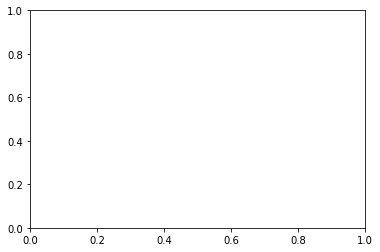

In [27]:
plt.plot(movie_data['movieId'],ratings_data['movieId'].value_counts().tolist())

In [35]:
df = ratings_data.groupby('movieId').agg({'rating':list})
df.ratings = df['rating'].apply(len)

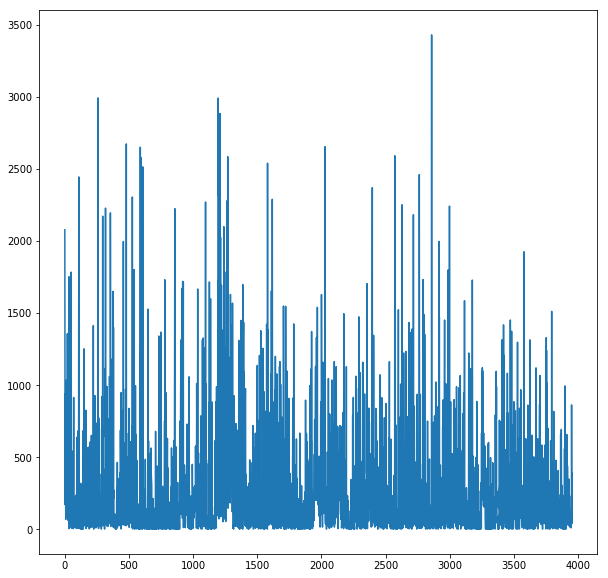

In [63]:
plt.figure(figsize=(10,10))
plt.plot(df.movieId,df.rating)

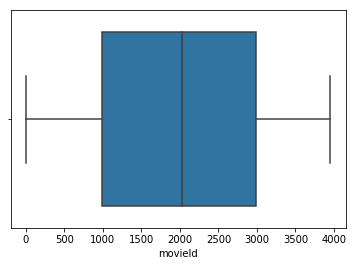

In [67]:
import seaborn as sns
sns.boxplot(x='movieId',hue='rating',data=df)

In [54]:
df = ratings_data.groupby('movieId').agg({'rating':list})

In [55]:
df['movieId']=df.index
df.rating = df.rating.apply(len)

In [56]:
df.columns

Index(['rating', 'movieId'], dtype='object')

In [57]:
df.movieId.shape

(3706,)

In [69]:
ratings_data.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [74]:
df = ratings_data.pivot(columns='userId',values='rating',index='movieId').fillna(0)

In [75]:
from scipy.sparse import csr_matrix

In [76]:
sparse_df = csr_matrix(df.values)

In [77]:
df.head(2)

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,6031.0,6032.0,6033.0,6034.0,6035.0,6036.0,6037.0,6038.0,6039.0,6040.0
movieId,,,,,,,,,,,,,,,,,,,,,
1.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
